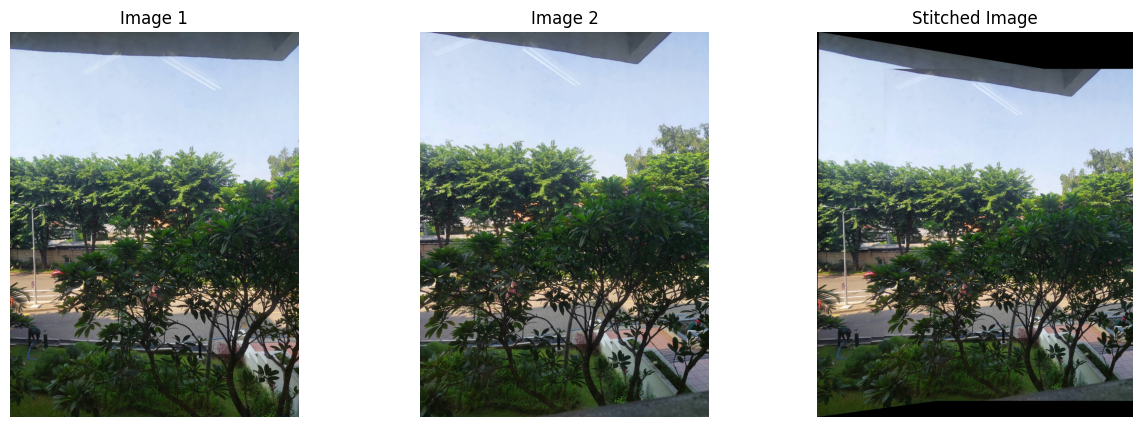

In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def stitch_images(image1, image2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Find keypoints and descriptors in both images
    keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

    # Initialize a Brute Force matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches based on distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Calculate Homography
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Warp image1 to image2
    height1, width1 = gray1.shape
    height2, width2 = gray2.shape
    corners1 = np.array([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2).astype(np.float32)
    corners2 = np.array([[0, 0], [0, height2], [width2, height2], [width2, 0]]).reshape(-1, 1, 2).astype(np.float32)
    corners_transformed1 = cv2.perspectiveTransform(corners1, H)
    corners_transformed = np.concatenate((corners2, corners_transformed1), axis=0)
    [x_min, y_min] = np.int32(corners_transformed.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(corners_transformed.max(axis=0).ravel() + 0.5)
    T = [-x_min, -y_min]
    H_translation = np.array([[1, 0, T[0]], [0, 1, T[1]], [0, 0, 1]])
    stitched_img = cv2.warpPerspective(image1, H_translation.dot(H), (x_max - x_min, y_max - y_min))
    stitched_img[T[1]:height2 + T[1], T[0]:width2 + T[0]] = image2

    return stitched_img

# Load input images
image1 = cv2.imread('a.jpg')
image2 = cv2.imread('b.jpg')

# Stitch images
stitched_img = stitch_images(image1, image2)

# Display the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
plt.title('Stitched Image')
plt.axis('off')

plt.show()
